# Mixed ANOVA

1. 个体间差异：形成人与人的分组，每个个体对应一个组
2. 个体内差异：每个个体对应多个因素水平，典型的例子是重复测量多次

前提条件：
1. 满足正态性
2. 各组满足方差齐性
3. 不同组的个体内变异一致(Mauchly’s test 球形检验)：

### 两因素混合方差分析：一个个体间因素，一个个体内因素

In [1]:
#推荐使用rstatix的anova_test()函数
library(tidyverse)
library(ggpubr)
library(rstatix)

Warning message:
"程辑包'tidyverse'是用R版本4.2.2 来建造的"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0      v purrr   0.3.5 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
Warning message:
"程辑包'ggplot2'是用R版本4.2.2 来建造的"
Warning message:
"程辑包'readr'是用R版本4.2.2 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.2.2 来建造的"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"程辑包'ggpubr'是用R版本4.2.2 来建造的"
Warning message:
"程辑包'rstatix'是用R版本4.2.2 来建造的"

载入程辑包：'rstatix'


The following object is masked from 'package:stats':

    filter




In [2]:
#举例：一群人根据体育锻炼水平分三组（低，中，高），
#测他们焦虑情况三次（锻炼前，中，后），欲了解锻炼水平和测验时间对焦虑测量的影响
data("anxiety", package = "datarium")
head(anxiety)

id,group,t1,t2,t3
<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,grp1,14.1,14.4,14.1
2,grp1,14.5,14.6,14.3
3,grp1,15.7,15.2,14.9
4,grp1,16.0,15.5,15.3
5,grp1,16.5,15.8,15.7
6,grp1,16.9,16.5,16.2


In [3]:
# 宽数据转长数据
anxiety <- anxiety %>%
  gather(key = "time", value = "score",t1,t2,t3) %>%
  convert_as_factor(id, time) 



In [4]:
head(anxiety)

id,group,time,score
<fct>,<fct>,<fct>,<dbl>
1,grp1,t1,14.1
2,grp1,t1,14.5
3,grp1,t1,15.7
4,grp1,t1,16.0
5,grp1,t1,16.5
6,grp1,t1,16.9


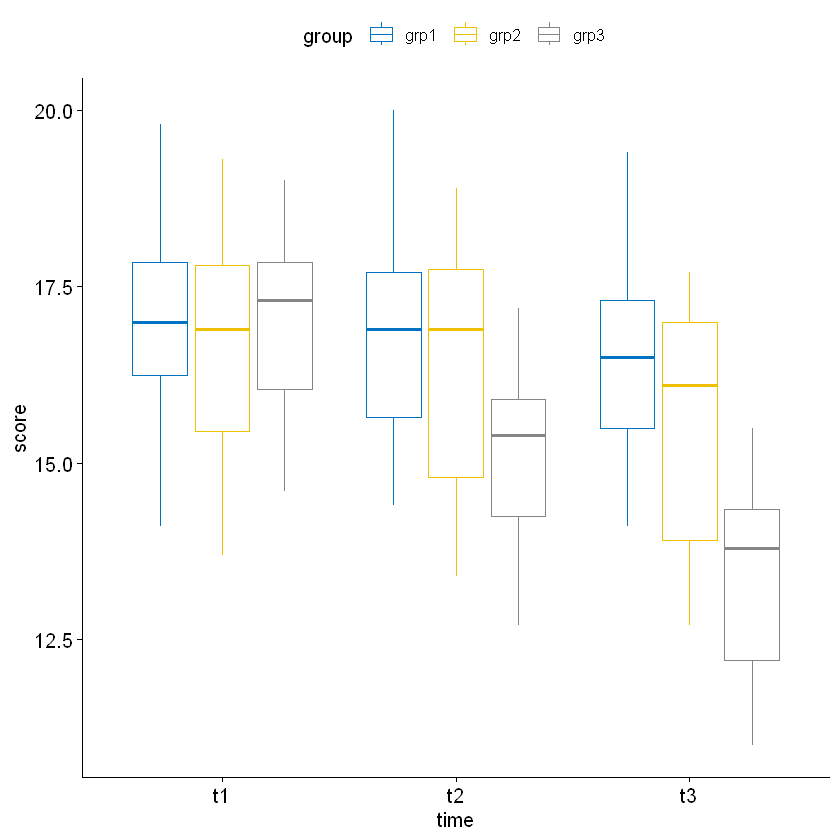

In [5]:
ggboxplot(
  anxiety, x = "time", y = "score",
  color = "group", palette = "jco"
  )


In [6]:
#检验正态性

anxiety %>%
  group_by(time, group) %>%
  shapiro_test(score)

group,time,variable,statistic,p
<fct>,<fct>,<chr>,<dbl>,<dbl>
grp1,t1,score,0.9644384,0.7689109
grp2,t1,score,0.9774363,0.9489758
grp3,t1,score,0.9539227,0.5881991
grp1,t2,score,0.9560505,0.6241596
grp2,t2,score,0.9354260,0.3283178
grp3,t2,score,0.9521172,0.5583945
grp1,t3,score,0.9488300,0.5062152
grp2,t3,score,0.9090953,0.1311525
grp3,t3,score,0.9253666,0.2324214


In [7]:
#检验方差齐性假设
bartlett.test(score ~ group, data=anxiety)


	Bartlett test of homogeneity of variances

data:  score by group
Bartlett's K-squared = 1.9311, df = 2, p-value = 0.3808


In [8]:
#nova_test()会直接返回球形检验结果
res.aov <- anova_test(
  data = anxiety, dv = score, wid = id,
  between = group, within = time
  )
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,group,2,42,4.352,1.90e-02,*,0.168
2,time,2,84,394.909,1.91e-43,*,0.179
3,group:time,4,84,110.188,1.38e-32,*,0.108


In [9]:
#使用anova_test()自动给到球形检验结果
res.aov

ANOVA Table (type II tests)

$ANOVA
      Effect DFn DFd       F        p p<.05   ges
1      group   2  42   4.352 1.90e-02     * 0.168
2       time   2  84 394.909 1.91e-43     * 0.179
3 group:time   4  84 110.188 1.38e-32     * 0.108

$`Mauchly's Test for Sphericity`
      Effect     W     p p<.05
1       time 0.884 0.079      
2 group:time 0.884 0.079      

$`Sphericity Corrections`
      Effect   GGe      DF[GG]    p[GG] p[GG]<.05   HFe      DF[HF]    p[HF]
1       time 0.896 1.79, 75.24 3.48e-39         * 0.933 1.87, 78.38 1.04e-40
2 group:time 0.896 3.58, 75.24 1.97e-29         * 0.933 3.73, 78.38 1.46e-30
  p[HF]<.05
1         *
2         *

In [10]:
#主效应结果
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,group,2,42,4.352,1.90e-02,*,0.168
2,time,2,84,394.909,1.91e-43,*,0.179
3,group:time,4,84,110.188,1.38e-32,*,0.108


In [11]:
#控制Time简单效应结果
anxiety %>%
  group_by(time) %>%
  anova_test(dv = score, wid = id, between = group) %>%
  get_anova_table() 

,time,Effect,DFn,DFd,F,p,p<.05,ges
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,t1,group,2,42,0.365,6.96e-01,,0.017
2,t2,group,2,42,5.845,6.00e-03,*,0.218
3,t3,group,2,42,13.796,2.48e-05,*,0.396


In [12]:
#控制group简单效应结果
anxiety %>%
  group_by(group) %>%
  anova_test(dv = score, wid = id, between = time) %>%
  get_anova_table() 

Warning message:
"The 'wid' column contains duplicate ids across between-subjects variables. Automatic unique id will be created"
Warning message:
"The 'wid' column contains duplicate ids across between-subjects variables. Automatic unique id will be created"
Warning message:
"The 'wid' column contains duplicate ids across between-subjects variables. Automatic unique id will be created"


,group,Effect,DFn,DFd,F,p,p<.05,ges
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,grp1,time,2,42,0.508,6.05e-01,,0.024
2,grp2,time,2,42,1.980,1.51e-01,,0.086
3,grp3,time,2,42,23.737,1.27e-07,*,0.531


In [13]:
#两两比较结果
anxiety %>%
  group_by(group) %>%
  pairwise_t_test(score ~ time)

,group,.y.,group1,group2,n1,n2,p,p.signif,p.adj,p.adj.signif
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>
1,grp1,score,t1,t2,15,15,7.89e-01,ns,1.00e+00,ns
2,grp1,score,t1,t3,15,15,3.35e-01,ns,1.00e+00,ns
3,grp1,score,t2,t3,15,15,4.84e-01,ns,1.00e+00,ns
4,grp2,score,t1,t2,15,15,7.67e-01,ns,7.67e-01,ns
5,grp2,score,t1,t3,15,15,7.10e-02,ns,2.13e-01,ns
6,grp2,score,t2,t3,15,15,1.27e-01,ns,2.55e-01,ns
7,grp3,score,t1,t2,15,15,2.72e-04,***,5.45e-04,***
8,grp3,score,t1,t3,15,15,2.29e-08,****,6.88e-08,****
9,grp3,score,t2,t3,15,15,6.11e-03,**,6.11e-03,**
